In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm

plt.style.use("~/.base_style.mplstyle")

In [2]:
data = pd.read_csv("data/ecdc_full_data.csv")
data = (
    data[
        data.location.isin(
            [
                "World",
                "France",
                "China",
                "United States",
                "Sweden",
                "Denmark",
                "Italy",
                "Spain",
                "United Kingdom",
                "Germany",
            ]
        )
    ]
    .loc[
        :,
        [
            "date",
            "location",
            "new_cases_smoothed",
            "total_cases",
            "new_deaths_smoothed",
            "total_deaths",
        ],
    ]
    .rename(
        columns={"new_cases_smoothed": "new_cases", "new_deaths_smoothed": "new_deaths"}
    )
    .dropna()
)
data.loc[:, ["new_cases", "new_deaths"]] = data.loc[
    :, ["new_cases", "new_deaths"]
].astype("int")
data["date"] = data.date.apply(pd.to_datetime)
data["date_str"] = data.date.apply(lambda x: x.strftime("%d/%m/%Y"))
data = data[data.date > "09/01/2020"]

dataf = data[data.location == "France"]
df = data[data.location != "World"]
# df = df.groupby("location").filter(lambda x: x.total_cases.values[-1] > 10000)

In [3]:
df.head()

,date,location,new_cases,total_cases,new_deaths,total_deaths,date_str
10440,2020-09-02,China,24,89953.0,2,4727.0,02/09/2020
10441,2020-09-03,China,24,89986.0,1,4728.0,03/09/2020
10442,2020-09-04,China,24,90008.0,1,4728.0,04/09/2020
10443,2020-09-05,China,23,90025.0,1,4728.0,05/09/2020
10444,2020-09-06,China,23,90058.0,1,4730.0,06/09/2020


In [4]:
def plot_reg(data, shift=0, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    res = sm.RLM(endog=data.new_deaths[shift:], exog=data.new_cases.shift(shift).dropna()).fit()
    res_OLS = sm.OLS(endog=data.new_deaths[shift:], exog=data.new_cases.shift(shift).dropna()).fit()

    sns.scatterplot(x=data.new_cases.shift(shift).dropna(), y=data.new_deaths[shift:], hue=res.weights, palette="RdBu", alpha=0.6, ax=ax)
    sns.lineplot(x=data.new_cases.shift(shift).dropna(), y=res.fittedvalues, ax=ax)
    sns.lineplot(x=data.new_cases.shift(shift).dropna(), y=res_OLS.fittedvalues, ax=ax)

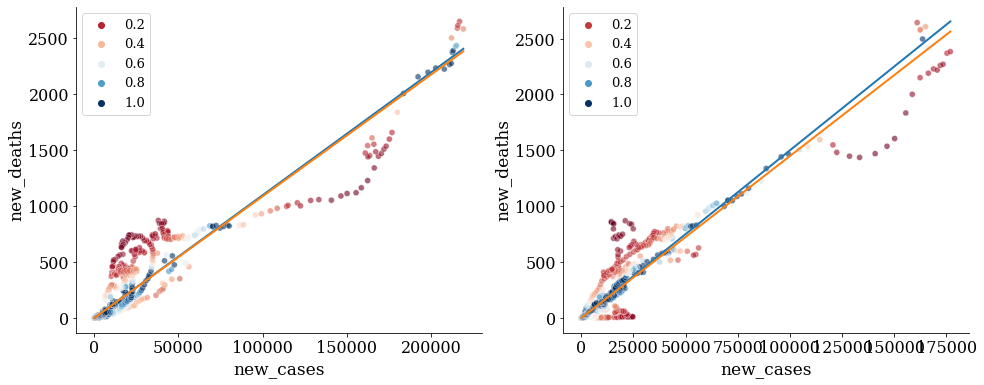

In [5]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_reg(df, shift=0, ax=ax[0])
plot_reg(df, shift=17, ax=ax[1])

In [31]:
def compute_pearson(x, shift=0):
    return stats.pearsonr(x.new_cases.shift(shift).dropna(), x.new_deaths[shift:])[0]

def get_rsquarred_shifted_reg(x, shift=0, robust=True):
    if robust:
        res = sm.RLM(endog=x.new_deaths[shift:], exog=x.new_cases.shift(shift).dropna()).fit()
        return ((res.resid * res.weights)**2).sum()
    else:
        res = sm.OLS(endog=x.new_deaths[shift:], exog=x.new_cases.shift(shift).dropna()).fit()
        return (res.resid**2).sum() 

def goodness_of_fit_shifted(data, n_shift=40, robust=True):
    p_ = []
    for k in tqdm(range(n_shift)):
        p = data.groupby("location").apply(lambda x: get_rsquarred_shifted_reg(x, shift=k, robust=robust))
        p = p.dropna()
        p_.append(p.mean())
        
    return np.stack(p_)

In [43]:
def plot_gof_vs_shift(gof, gof_robust, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(gof, label="OLS residual")
    ax.plot(np.argmin(gof), np.min(gof), 'o', label=f"Min residual : {np.argmin(gof)}")
    ax.plot(gof_robust, label="RLM residual");
    ax.plot(np.argmin(gof_robust), np.min(gof_robust), 'o', label=f"Min residual : {np.argmin(gof_robust)}")
    ax.legend()

100%|██████████| 40/40 [00:00<00:00, 250.34it/s]


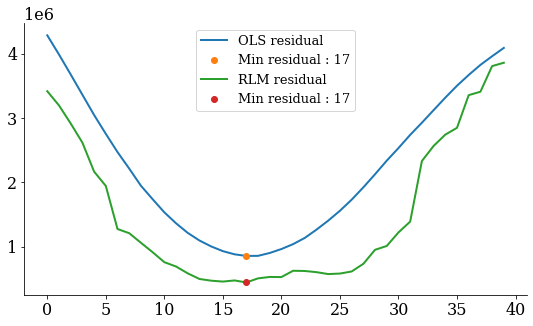

In [44]:
gof_robust = goodness_of_fit_shifted(dataf, robust=True)
gof = goodness_of_fit_shifted(dataf, robust=False)
plot_gof_vs_shift(gof, gof_robust)

100%|██████████| 40/40 [00:00<00:00, 66.15it/s]


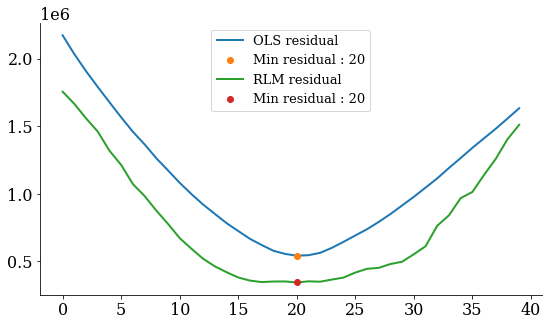

In [46]:
gof_robust = goodness_of_fit_shifted(df, robust=True)
gof = goodness_of_fit_shifted(df, robust=False)
plot_gof_vs_shift(gof, gof_robust)